# interrupting and continuing of a simulation with a source

In this example the simulation uses a `sourceInterface` and allows for the production of secondaries.

The source emmits a limited number of photons ($n = 100$) with an energy $E = 100 \, \mathrm{TeV}$ at a distance of $D = 50 \, \mathrm{Mpc}$. The photons are propagated in 1D to the observer, taking interactions with the CMB and EBL into account. 

The interrupted simulation contains three different parts: (1) the candidates arriving at the observer before the simulation is interrupted, (2) the candidates which are in the simulation at the point of interruption and (3) the particles which have not been started before the interruption. In the case of secondaries the number of particles which are contained in the simulation is much larger than the number of cores. 

In the end, the SED of the arriving photons is compared. Small differences between the full and the interrupted simulation are expected due to the Monte-Carlo nature of the interactions. 

In [1]:
from crpropa import * 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 

In [2]:
def read_crp(file): 
    with open(file, "r") as f: 
        names = f.readline().strip("\n").split("\t")[1:]
    
    return pd.read_csv(file, delimiter="\t", comment ="#", names = names)

## full simulation

In [3]:
n_sim = int(100)

def get_sim(file):
    sim = ModuleList() 
    sim.add(SimplePropagation())

    # add EM interactions 
    photon_fields = [CMB(), IRB_Gilmore12()]
    for field in photon_fields:
        sim.add(EMInverseComptonScattering(field, True)) # allow photons
        sim.add(EMPairProduction(field, True)) # allow electrons 
        sim.add(EMDoublePairProduction(field, True))
        sim.add(EMTripletPairProduction(field, True))

    sim.add(MinimumEnergy(10 * GeV))

    sub_dir = "cascade/"
    os.makedirs(sub_dir, exist_ok=True)
    out = TextOutput(f"{sub_dir}/{file}")
    out.setEnergyScale(TeV)
    obs = Observer() 
    obs.add(Observer1D())
    obs.add(ObserverInactiveVeto())
    obs.onDetection(out)
    sim.add(obs) 

    source = Source() 
    source.add(SourceParticleType(22))
    source.add(SourcePosition(Vector3d(50 * Mpc, 0, 0)))
    source.add(SourceEnergy(100 * TeV))

    sim.setShowProgress(True)
    return source, sim, out

source, sim, out = get_sim("full.txt")
sim.run(source, n_sim)
out.close()

crpropa::ModuleList: Number of Threads: 12
Run ModuleList
  Started Thu Sep  5 14:07:59 2024 : [ Finished ] 100%    Needed: 00:01:39  - Finished at Thu Sep  5 14:09:38 2024


In [4]:
# load data 
df_full = read_crp("cascade/full.txt")

## interrupted simulation

In [5]:
source, sim, out = get_sim("interrupt_1.txt")

interrupt_out = TextOutput(f"cascade/on_interrupt.txt")
sim.setInterruptAction(interrupt_out)

sim.run(source, n_sim)

crpropa::ModuleList: Number of Threads: 12
Run ModuleList


crpropa::ModuleList: Signal 2 (SIGINT/SIGTERM) received


############################################################################
# Interrupted CRPropa simulation 
# Number of not started candidates from source: 69
############################################################################


KeyboardInterrupt: 

In [6]:
# close datafile to avoid data loss
out.close()

In [7]:
df_1 = read_crp(f"cascade/interrupt_1.txt") # at state of interruption

In [8]:
n_missing = 69 # taken from output -> will be different on each try

source, sim, out = get_sim("interrupt_2.txt")
sim.run(source, n_missing) # use modulelist and source as previously defined
out.close()

crpropa::ModuleList: Number of Threads: 12
Run ModuleList
  Started Thu Sep  5 14:10:30 2024 : [ Finished ] 100%    Needed: 00:01:08  - Finished at Thu Sep  5 14:11:38 2024


In [9]:
df_2 = read_crp(f"cascade/interrupt_2.txt")

In [10]:
# close outputfile before reading 
interrupt_out.close()

pc = ParticleCollector()
pc.load("cascade/on_interrupt.txt")

print("number of loaded particles:", pc.size())

# run simulation with missing particles
source, sim, out = get_sim("interrupt_3.txt")
sim.run(pc.getContainer())
out.close()

number of loaded particles: 5690
crpropa::ModuleList: Number of Threads: 12
Run ModuleList
  Started Thu Sep  5 14:11:38 2024 : [ Finished ] 100%    Needed: 00:00:00  - Finished at Thu Sep  5 14:11:38 2024


In [11]:
try:
    df_3 = read_crp("cascade/interrupt_3.txt")
except: 
    # it can happen that all particles from the interruption time are cascaded to lower energies than the minimum energy
    # in this case the dataset will be empty
    print("no data from interrupt_3.txt")
    df_3 = pd.DataFrame({"E":[], "ID":[]})

## show spectrum at earth

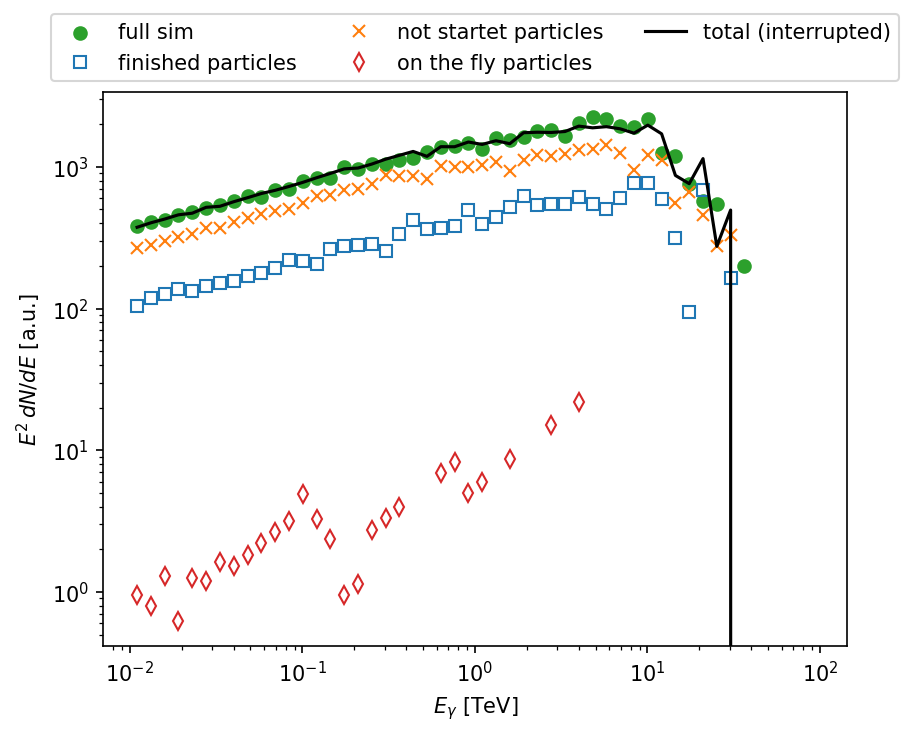

In [12]:
e_bins = np.logspace(-2, 2, 51)
dE = np.diff(e_bins)
e_mid = 0.5 * (e_bins[1:] + e_bins[:-1])

get_dnde = lambda df: np.histogram(df[df.ID == 22].E, bins = e_bins)[0]/dE 

dNdE_full = get_dnde(df_full)
dNdE_1 = get_dnde(df_1)
dNdE_2 = get_dnde(df_2)
dNdE_3 = get_dnde(df_3) 

plt.figure(dpi = 150)
plt.scatter(e_mid, e_mid**2 * dNdE_full, label = "full sim", color = "tab:green") 
plt.plot(e_mid, e_mid**2 * dNdE_1, label = "finished particles", marker ="s", ls = "", fillstyle="none")
plt.plot(e_mid, e_mid**2 * dNdE_2, label = "not startet particles", marker ="x", ls = "", )
plt.plot(e_mid, e_mid**2 * dNdE_3, label = "on the fly particles", fillstyle="none", ls = "",marker ="d", color = "tab:red")

plt.plot(e_mid, e_mid**2 * (dNdE_1 + dNdE_2 + dNdE_3), label ="total (interrupted)", color ="k")


plt.loglog() 
plt.xlabel(r"$E_\gamma$ [TeV]")
plt.ylabel(r"$E^2 \, dN/dE$ [a.u.]")
plt.legend(loc = "lower center", ncol = 3, bbox_to_anchor=(0.5, 1.))
plt.show()